Machine Learning Housing Price Predictor

Practice an end-to-end ML project in the context of a **regression** problem in the [Ames Housing Dataset on Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

## Step 1: Big Picture and Setup


The task is to use regression for predicting housing prices in Ames, Iowa based on a wide variety of different factors. The model would likely assist in property valuation for homeowners, real estate agents, buyers, etc. To evaluate the model's performance, the Root Mean Square Error (RMSE) metric will be used along with a 5-fold cross-validation. The data is provided in a training csv with over 1400 data points, which should be a large enough dataset to analyze and model off of. The learning algorithms that will be used are linear regression, decision tree regression, and random forest regression.

## Step 2: Load the Data


In [ ]:
import pandas as pd
import os

# To help you get started, a load function is provided below.
# You will need to fill in the code under #TODO to make it work.
def loadAmesHousingData():
    # The column names are adopted from the dataset page on Kaggle
    housing = pd.read_csv('train.csv')
    return housing

housing = loadAmesHousingData()

# check size (in terms of MB)
file_info = os.stat('train.csv')
size_in_MB = file_info.st_size / (1024 * 1024)
print(f"Size of the dataset: {size_in_MB:.2f} MB")

# check the number of entries and features
num_entries, num_features = housing.shape
print(f"Number of entries: {num_entries}")
print(f"Number of features: {num_features}")

# check for categorical data
categorical_features = housing.select_dtypes(include=['object']).columns
print(f"Number of categorical features: {len(categorical_features)}")

# check for missing values
missing_values = housing.isnull().sum()
num_missing = missing_values[missing_values > 0].shape[0]
print(f"Number of features with missing values: {num_missing}")

# basic statistics
print("\nBasic statistics for the dataset:")
print(housing.describe())

Size of the dataset: 0.44 MB
Number of entries: 1460
Number of features: 81
Number of categorical features: 43
Number of features with missing values: 19

Basic statistics for the dataset:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000 

## Step 3. Discover and visualize the data to gain insights


<ipython-input-22-63ca43b95d93>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


SalePrice: 1.0000
OverallQual: 0.7910
GrLivArea: 0.7086
GarageCars: 0.6404
GarageArea: 0.6234
TotalBsmtSF: 0.6136
1stFlrSF: 0.6059
FullBath: 0.5607
TotRmsAbvGrd: 0.5337
YearBuilt: 0.5229
YearRemodAdd: 0.5071


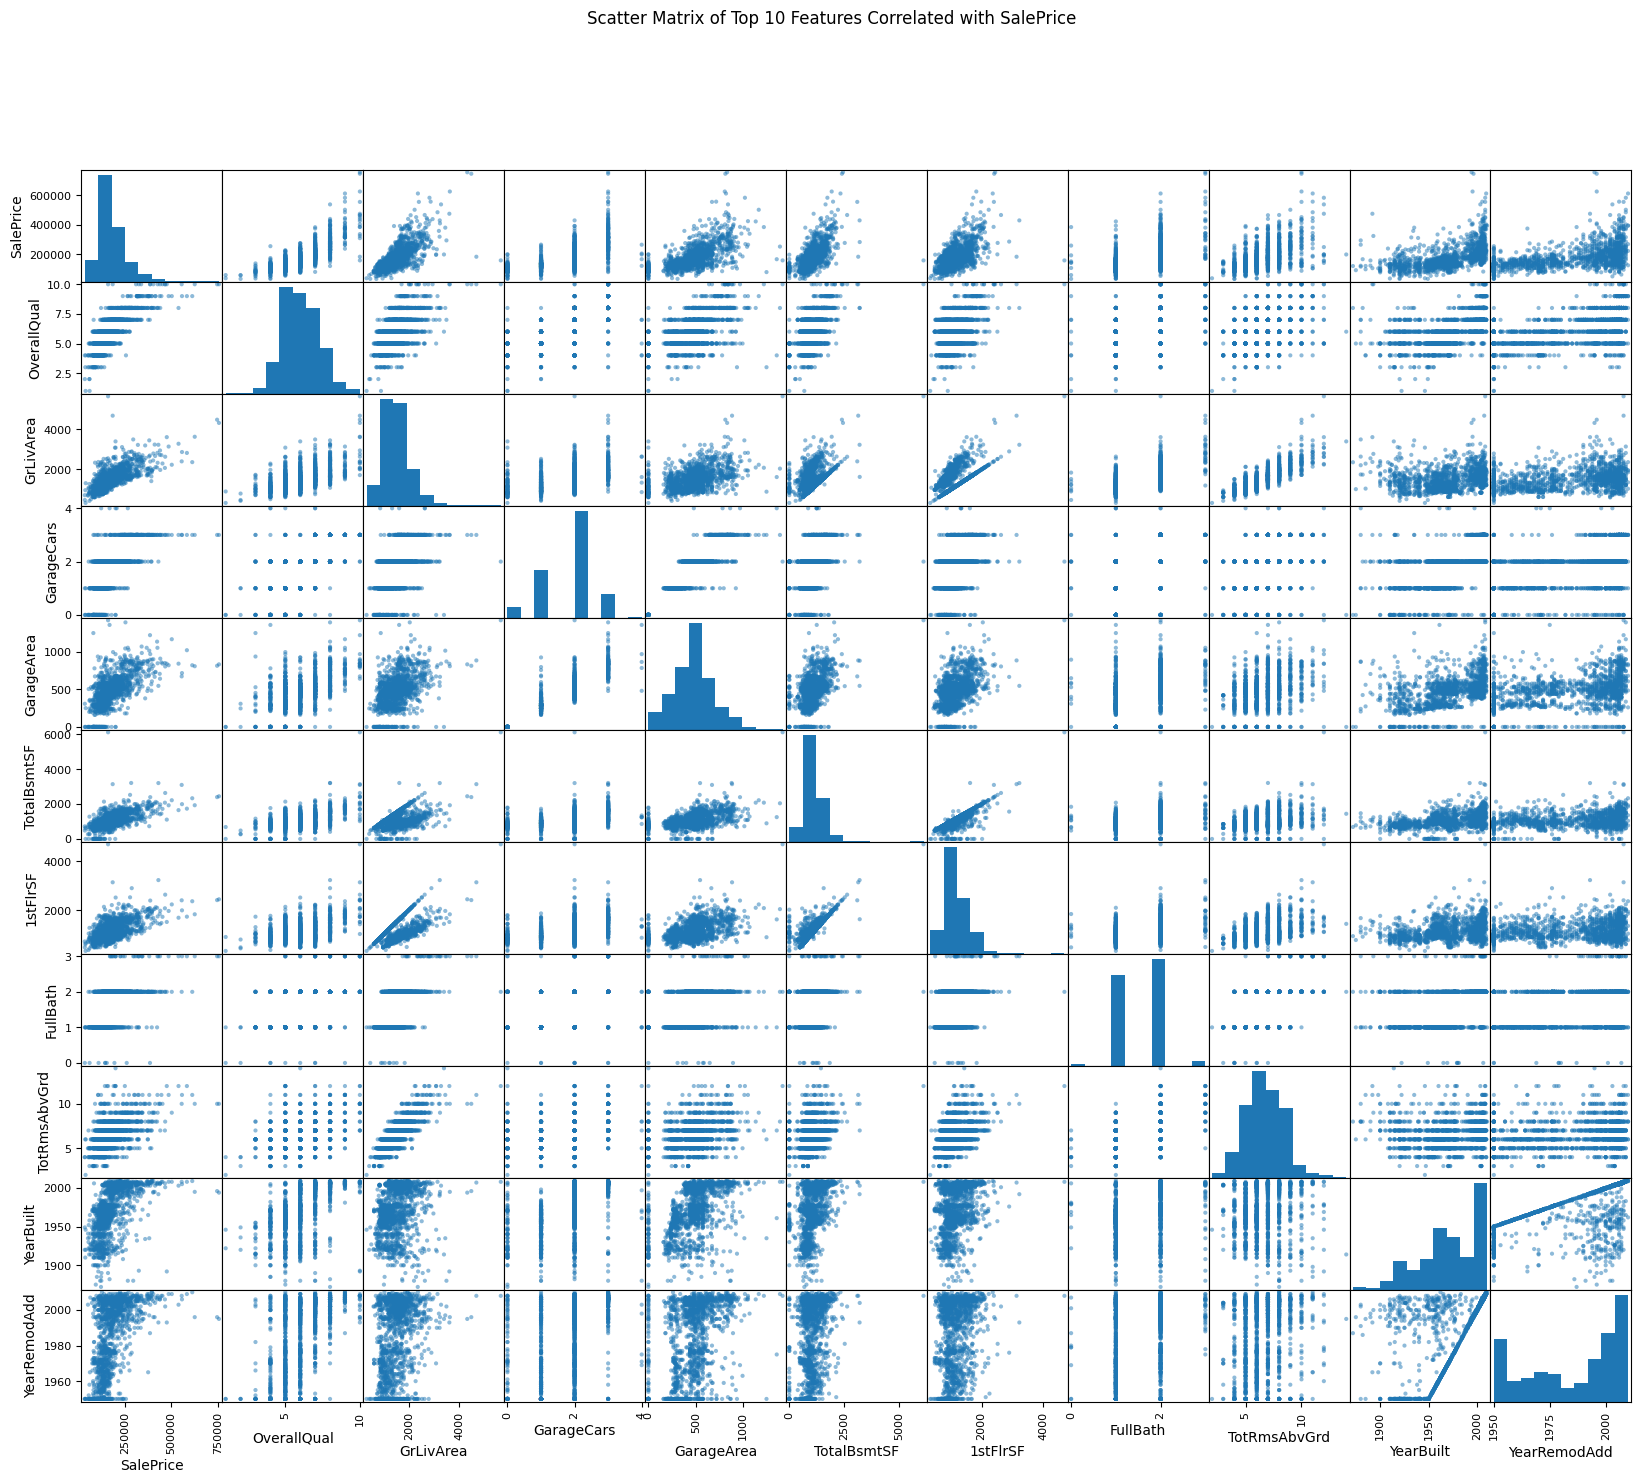

In [ ]:
# Your code to visualize the data here
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = housing.corr()

saleprice_corr = corr_matrix["SalePrice"].sort_values(ascending=False)

# top 10 features most correlated with SalePrice
for feature, corr_value in saleprice_corr.head(11).items():
    print(f"{feature}: {corr_value:.4f}")

top_n = 10
attributes = saleprice_corr.head(top_n + 1).index.tolist()

# scatter matrix for top 10 features
from pandas.plotting import scatter_matrix

scatter_matrix(housing[attributes], figsize=(20, 16))
plt.suptitle("Scatter Matrix of Top {} Features Correlated with SalePrice".format(top_n))
plt.show()


Text(0.5, 0.98, 'Size of garage in car capacity vs. SalePrice Scatterplot')

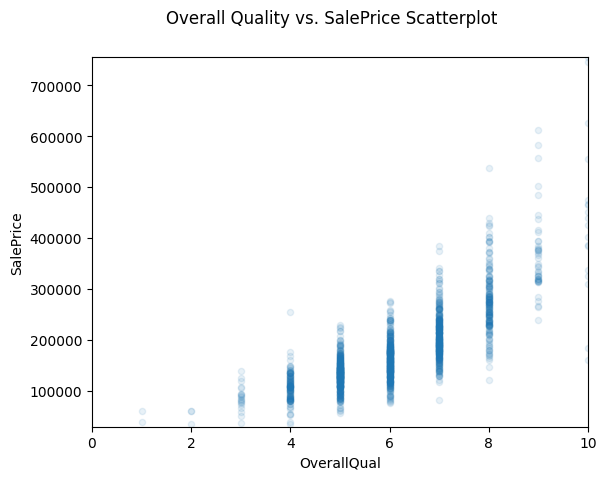

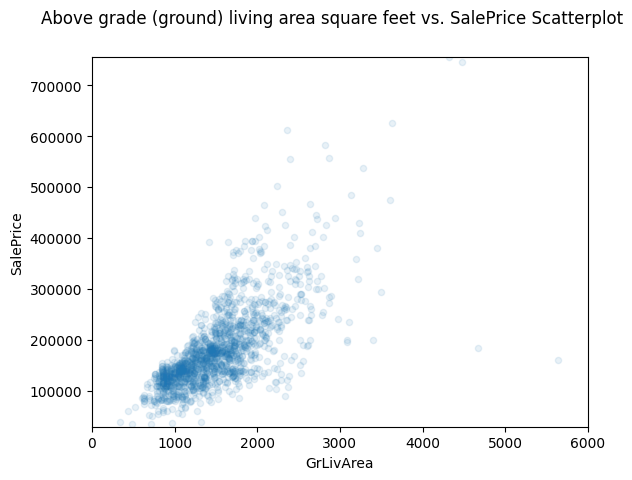

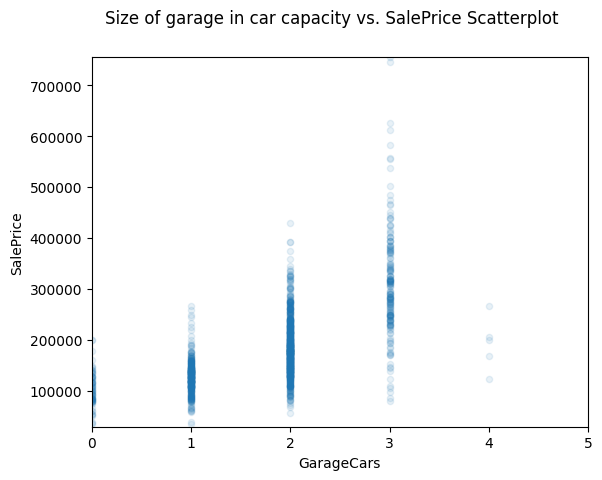

In [ ]:
housing.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.1)
plt.axis([0, 10, 30000, 755000])
plt.suptitle("Overall Quality vs. SalePrice Scatterplot".format(top_n))

housing.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.1)
plt.axis([0, 6000, 30000, 755000])
plt.suptitle("Above grade (ground) living area square feet vs. SalePrice Scatterplot".format(top_n))


housing.plot(kind="scatter", x="GarageCars", y="SalePrice", alpha=0.1)
plt.axis([0, 5, 30000, 755000])
plt.suptitle("Size of garage in car capacity vs. SalePrice Scatterplot".format(top_n))


##  Step 4: Data Preparation and Cleaning


In [ ]:
from sklearn.model_selection import train_test_split

# split the data into train and test sets (80% train, 20% test)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# split the train set again into training and validation sets (80% train, 20% validation)
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

train_set.shape, val_set.shape, test_set.shape


((934, 81), (234, 81), (292, 81))

In [ ]:
num_attribs = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_attribs = train_set.select_dtypes(include=['object']).columns.tolist()

num_attribs.remove('SalePrice')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

train_prepared = full_pipeline.fit_transform(train_set.drop("SalePrice", axis=1))
val_prepared = full_pipeline.transform(val_set.drop("SalePrice", axis=1))
test_prepared = full_pipeline.transform(test_set.drop("SalePrice", axis=1))

train_prepared.shape, val_prepared.shape, test_prepared.shape


((934, 284), (234, 284), (292, 284))

## Step 5: Model Selection



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

train_label = train_set["SalePrice"]

# Linear Regression
print("Linear Regression")
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, train_prepared, train_label, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# Decision Tree Regressor
print("\nDecision Tree Regressor")
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, train_prepared, train_label, scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

# Random Forest Regressor
print("\nRandom Forest Regressor")
forest_reg = RandomForestRegressor(random_state=42)
forest_scores = cross_val_score(forest_reg, train_prepared, train_label, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Linear Regression
Scores: [26321.38729212 62858.99817624 23677.57946917 37902.51629848
 43999.12385367]
Mean: 38951.92101793531
Standard Deviation: 14078.066180629306

Decision Tree Regressor
Scores: [38008.56366248 53264.5026528  37563.7815009  40413.73650531
 42323.41017554]
Mean: 42314.79889940544
Standard Deviation: 5738.047627968087

Random Forest Regressor
Scores: [28392.22107038 46873.49036068 22897.52061196 28371.01772733
 25941.02830151]
Mean: 30495.0556143702
Standard Deviation: 8433.839904611847


## Step 6: Model Tuning



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(train_prepared, train_label)

print(f"Best hyperparameters: {grid_search.best_params_}")

print(f"Best model: {grid_search.best_estimator_}")

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


Best hyperparameters: {'max_features': 8, 'n_estimators': 30}
Best model: RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)
49445.06191810649 {'max_features': 2, 'n_estimators': 3}
40960.08057541921 {'max_features': 2, 'n_estimators': 10}
39339.242003794265 {'max_features': 2, 'n_estimators': 30}
44560.37187631985 {'max_features': 4, 'n_estimators': 3}
39568.47190915779 {'max_features': 4, 'n_estimators': 10}
37085.919833749336 {'max_features': 4, 'n_estimators': 30}
46566.08780588187 {'max_features': 6, 'n_estimators': 3}
37526.39082762931 {'max_features': 6, 'n_estimators': 10}
35580.25037164239 {'max_features': 6, 'n_estimators': 30}
43647.48350809254 {'max_features': 8, 'n_estimators': 3}
36613.16798317662 {'max_features': 8, 'n_estimators': 10}
34909.277887380296 {'max_features': 8, 'n_estimators': 30}
44792.90675385841 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
38408.155391964414 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
435

In [ ]:
from sklearn.metrics import mean_squared_error

test_label = test_set["SalePrice"]

final_model1 = grid_search.best_estimator_

final_predictions1 = final_model1.predict(test_prepared)

final_rmse1 = np.sqrt(mean_squared_error(test_label, final_predictions1))

print(f"The final RMSE on the test set is: {final_rmse1:.2f}")



The final RMSE on the test set is: 37979.75


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#RandomizedSearchCV
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(train_prepared, train_label)

print(f"Best hyperparameters: {rnd_search.best_params_}")

print(f"Best model: {rnd_search.best_estimator_}")

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


Best hyperparameters: {'max_features': 7, 'n_estimators': 122}
Best model: RandomForestRegressor(max_features=7, n_estimators=122, random_state=42)
34341.889089339405 {'max_features': 7, 'n_estimators': 180}
38303.76906924994 {'max_features': 5, 'n_estimators': 15}
37230.117530177864 {'max_features': 3, 'n_estimators': 72}
37153.500728942585 {'max_features': 5, 'n_estimators': 21}
34208.75952587506 {'max_features': 7, 'n_estimators': 122}
37147.79056406553 {'max_features': 3, 'n_estimators': 75}
37059.443886595946 {'max_features': 3, 'n_estimators': 88}
35622.87544977234 {'max_features': 5, 'n_estimators': 100}
36660.77185216188 {'max_features': 3, 'n_estimators': 150}
51059.17412545542 {'max_features': 5, 'n_estimators': 2}


In [ ]:
from sklearn.metrics import mean_squared_error

test_label = test_set["SalePrice"]

final_model = rnd_search.best_estimator_

final_predictions = final_model.predict(test_prepared)

final_rmse = np.sqrt(mean_squared_error(test_label, final_predictions))

print(f"The final RMSE on the test set is: {final_rmse:.2f}")


The final RMSE on the test set is: 37925.86


## Step 7: Solution Presentation


**Final Analysis:** Using a combination of techniques and thorough analysis, my model can predict housing prices with a final error of \$37925.86, meaning the prediction would be off by \$37925.86. Hyperparameter tuning was performed using two techniques GridSearchCV and RandomizedSearchCV, returning a final  root mean square error (RMSE) on the test set of \$37979.75 and \$37925.86 respectively. This means that housing prices in Ames, Iowa can be predicted using machine models within a reasonable degree of accuracy from a wide variety of variables. These variables ranged from overall quality and above grade (ground) living area square feet which seem to have higher correlation with sales price to less correlated variables like enclosed porch area in square feet. Simpler models such as linear regression provided a good starting point with a RMSE score of \$38951.92, but more complex models like the random forest regressor had better performance with RMSE score \$30495.06, meaning they were closer to the actual value. Furthermore, hyperparameter tuning followed by using the tuned model on the test set did worse and resulted in a greater RMSE score than the random forest regressor model on the training data. This could be attributed to overfitting the training data. With 81 different features, the model could have been too complex and captured underlying patterns in the data that would not necessarily translate to performance on the testing data. There is also more room to improve. More recent market data could be used for training or more advanced machine learning techniques like artificial neural networks could be incorporated to help reduce this error and offer more precise estimates.
